In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Thu Dec 28 09:45:28 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
import torch
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [ ]:
class_idx_to_name = {"0": ["n01440764", "tench"], "1": ["n01443537", "goldfish"], "2": ["n01484850", "great_white_shark"], "3": ["n01491361", "tiger_shark"], "4": ["n01494475", "hammerhead"], "5": ["n01496331", "electric_ray"], "6": ["n01498041", "stingray"], "7": ["n01514668", "cock"], "8": ["n01514859", "hen"], "9": ["n01518878", "ostrich"], "10": ["n01530575", "brambling"], "11": ["n01531178", "goldfinch"], "12": ["n01532829", "house_finch"], "13": ["n01534433", "junco"], "14": ["n01537544", "indigo_bunting"], "15": ["n01558993", "robin"], "16": ["n01560419", "bulbul"], "17": ["n01580077", "jay"], "18": ["n01582220", "magpie"], "19": ["n01592084", "chickadee"], "20": ["n01601694", "water_ouzel"], "21": ["n01608432", "kite"], "22": ["n01614925", "bald_eagle"], "23": ["n01616318", "vulture"], "24": ["n01622779", "great_grey_owl"], "25": ["n01629819", "European_fire_salamander"], "26": ["n01630670", "common_newt"], "27": ["n01631663", "eft"], "28": ["n01632458", "spotted_salamander"], "29": ["n01632777", "axolotl"], "30": ["n01641577", "bullfrog"], "31": ["n01644373", "tree_frog"], "32": ["n01644900", "tailed_frog"], "33": ["n01664065", "loggerhead"], "34": ["n01665541", "leatherback_turtle"], "35": ["n01667114", "mud_turtle"], "36": ["n01667778", "terrapin"], "37": ["n01669191", "box_turtle"], "38": ["n01675722", "banded_gecko"], "39": ["n01677366", "common_iguana"], "40": ["n01682714", "American_chameleon"], "41": ["n01685808", "whiptail"], "42": ["n01687978", "agama"], "43": ["n01688243", "frilled_lizard"], "44": ["n01689811", "alligator_lizard"], "45": ["n01692333", "Gila_monster"], "46": ["n01693334", "green_lizard"], "47": ["n01694178", "African_chameleon"], "48": ["n01695060", "Komodo_dragon"], "49": ["n01697457", "African_crocodile"], "50": ["n01698640", "American_alligator"], "51": ["n01704323", "triceratops"], "52": ["n01728572", "thunder_snake"], "53": ["n01728920", "ringneck_snake"], "54": ["n01729322", "hognose_snake"], "55": ["n01729977", "green_snake"], "56": ["n01734418", "king_snake"], "57": ["n01735189", "garter_snake"], "58": ["n01737021", "water_snake"], "59": ["n01739381", "vine_snake"], "60": ["n01740131", "night_snake"], "61": ["n01742172", "boa_constrictor"], "62": ["n01744401", "rock_python"], "63": ["n01748264", "Indian_cobra"], "64": ["n01749939", "green_mamba"], "65": ["n01751748", "sea_snake"], "66": ["n01753488", "horned_viper"], "67": ["n01755581", "diamondback"], "68": ["n01756291", "sidewinder"], "69": ["n01768244", "trilobite"], "70": ["n01770081", "harvestman"], "71": ["n01770393", "scorpion"], "72": ["n01773157", "black_and_gold_garden_spider"], "73": ["n01773549", "barn_spider"], "74": ["n01773797", "garden_spider"], "75": ["n01774384", "black_widow"], "76": ["n01774750", "tarantula"], "77": ["n01775062", "wolf_spider"], "78": ["n01776313", "tick"], "79": ["n01784675", "centipede"], "80": ["n01795545", "black_grouse"], "81": ["n01796340", "ptarmigan"], "82": ["n01797886", "ruffed_grouse"], "83": ["n01798484", "prairie_chicken"], "84": ["n01806143", "peacock"], "85": ["n01806567", "quail"], "86": ["n01807496", "partridge"], "87": ["n01817953", "African_grey"], "88": ["n01818515", "macaw"], "89": ["n01819313", "sulphur-crested_cockatoo"], "90": ["n01820546", "lorikeet"], "91": ["n01824575", "coucal"], "92": ["n01828970", "bee_eater"], "93": ["n01829413", "hornbill"], "94": ["n01833805", "hummingbird"], "95": ["n01843065", "jacamar"], "96": ["n01843383", "toucan"], "97": ["n01847000", "drake"], "98": ["n01855032", "red-breasted_merganser"], "99": ["n01855672", "goose"], "100": ["n01860187", "black_swan"], "101": ["n01871265", "tusker"], "102": ["n01872401", "echidna"], "103": ["n01873310", "platypus"], "104": ["n01877812", "wallaby"], "105": ["n01882714", "koala"], "106": ["n01883070", "wombat"], "107": ["n01910747", "jellyfish"], "108": ["n01914609", "sea_anemone"], "109": ["n01917289", "brain_coral"], "110": ["n01924916", "flatworm"], "111": ["n01930112", "nematode"], "112": ["n01943899", "conch"], "113": ["n01944390", "snail"], "114": ["n01945685", "slug"], "115": ["n01950731", "sea_slug"], "116": ["n01955084", "chiton"], "117": ["n01968897", "chambered_nautilus"], "118": ["n01978287", "Dungeness_crab"], "119": ["n01978455", "rock_crab"], "120": ["n01980166", "fiddler_crab"], "121": ["n01981276", "king_crab"], "122": ["n01983481", "American_lobster"], "123": ["n01984695", "spiny_lobster"], "124": ["n01985128", "crayfish"], "125": ["n01986214", "hermit_crab"], "126": ["n01990800", "isopod"], "127": ["n02002556", "white_stork"], "128": ["n02002724", "black_stork"], "129": ["n02006656", "spoonbill"], "130": ["n02007558", "flamingo"], "131": ["n02009229", "little_blue_heron"], "132": ["n02009912", "American_egret"], "133": ["n02011460", "bittern"], "134": ["n02012849", "crane"], "135": ["n02013706", "limpkin"], "136": ["n02017213", "European_gallinule"], "137": ["n02018207", "American_coot"], "138": ["n02018795", "bustard"], "139": ["n02025239", "ruddy_turnstone"], "140": ["n02027492", "red-backed_sandpiper"], "141": ["n02028035", "redshank"], "142": ["n02033041", "dowitcher"], "143": ["n02037110", "oystercatcher"], "144": ["n02051845", "pelican"], "145": ["n02056570", "king_penguin"], "146": ["n02058221", "albatross"], "147": ["n02066245", "grey_whale"], "148": ["n02071294", "killer_whale"], "149": ["n02074367", "dugong"], "150": ["n02077923", "sea_lion"], "151": ["n02085620", "Chihuahua"], "152": ["n02085782", "Japanese_spaniel"], "153": ["n02085936", "Maltese_dog"], "154": ["n02086079", "Pekinese"], "155": ["n02086240", "Shih-Tzu"], "156": ["n02086646", "Blenheim_spaniel"], "157": ["n02086910", "papillon"], "158": ["n02087046", "toy_terrier"], "159": ["n02087394", "Rhodesian_ridgeback"], "160": ["n02088094", "Afghan_hound"], "161": ["n02088238", "basset"], "162": ["n02088364", "beagle"], "163": ["n02088466", "bloodhound"], "164": ["n02088632", "bluetick"], "165": ["n02089078", "black-and-tan_coonhound"], "166": ["n02089867", "Walker_hound"], "167": ["n02089973", "English_foxhound"], "168": ["n02090379", "redbone"], "169": ["n02090622", "borzoi"], "170": ["n02090721", "Irish_wolfhound"], "171": ["n02091032", "Italian_greyhound"], "172": ["n02091134", "whippet"], "173": ["n02091244", "Ibizan_hound"], "174": ["n02091467", "Norwegian_elkhound"], "175": ["n02091635", "otterhound"], "176": ["n02091831", "Saluki"], "177": ["n02092002", "Scottish_deerhound"], "178": ["n02092339", "Weimaraner"], "179": ["n02093256", "Staffordshire_bullterrier"], "180": ["n02093428", "American_Staffordshire_terrier"], "181": ["n02093647", "Bedlington_terrier"], "182": ["n02093754", "Border_terrier"], "183": ["n02093859", "Kerry_blue_terrier"], "184": ["n02093991", "Irish_terrier"], "185": ["n02094114", "Norfolk_terrier"], "186": ["n02094258", "Norwich_terrier"], "187": ["n02094433", "Yorkshire_terrier"], "188": ["n02095314", "wire-haired_fox_terrier"], "189": ["n02095570", "Lakeland_terrier"], "190": ["n02095889", "Sealyham_terrier"], "191": ["n02096051", "Airedale"], "192": ["n02096177", "cairn"], "193": ["n02096294", "Australian_terrier"], "194": ["n02096437", "Dandie_Dinmont"], "195": ["n02096585", "Boston_bull"], "196": ["n02097047", "miniature_schnauzer"], "197": ["n02097130", "giant_schnauzer"], "198": ["n02097209", "standard_schnauzer"], "199": ["n02097298", "Scotch_terrier"], "200": ["n02097474", "Tibetan_terrier"], "201": ["n02097658", "silky_terrier"], "202": ["n02098105", "soft-coated_wheaten_terrier"], "203": ["n02098286", "West_Highland_white_terrier"], "204": ["n02098413", "Lhasa"], "205": ["n02099267", "flat-coated_retriever"], "206": ["n02099429", "curly-coated_retriever"], "207": ["n02099601", "golden_retriever"], "208": ["n02099712", "Labrador_retriever"], "209": ["n02099849", "Chesapeake_Bay_retriever"], "210": ["n02100236", "German_short-haired_pointer"], "211": ["n02100583", "vizsla"], "212": ["n02100735", "English_setter"], "213": ["n02100877", "Irish_setter"], "214": ["n02101006", "Gordon_setter"], "215": ["n02101388", "Brittany_spaniel"], "216": ["n02101556", "clumber"], "217": ["n02102040", "English_springer"], "218": ["n02102177", "Welsh_springer_spaniel"], "219": ["n02102318", "cocker_spaniel"], "220": ["n02102480", "Sussex_spaniel"], "221": ["n02102973", "Irish_water_spaniel"], "222": ["n02104029", "kuvasz"], "223": ["n02104365", "schipperke"], "224": ["n02105056", "groenendael"], "225": ["n02105162", "malinois"], "226": ["n02105251", "briard"], "227": ["n02105412", "kelpie"], "228": ["n02105505", "komondor"], "229": ["n02105641", "Old_English_sheepdog"], "230": ["n02105855", "Shetland_sheepdog"], "231": ["n02106030", "collie"], "232": ["n02106166", "Border_collie"], "233": ["n02106382", "Bouvier_des_Flandres"], "234": ["n02106550", "Rottweiler"], "235": ["n02106662", "German_shepherd"], "236": ["n02107142", "Doberman"], "237": ["n02107312", "miniature_pinscher"], "238": ["n02107574", "Greater_Swiss_Mountain_dog"], "239": ["n02107683", "Bernese_mountain_dog"], "240": ["n02107908", "Appenzeller"], "241": ["n02108000", "EntleBucher"], "242": ["n02108089", "boxer"], "243": ["n02108422", "bull_mastiff"], "244": ["n02108551", "Tibetan_mastiff"], "245": ["n02108915", "French_bulldog"], "246": ["n02109047", "Great_Dane"], "247": ["n02109525", "Saint_Bernard"], "248": ["n02109961", "Eskimo_dog"], "249": ["n02110063", "malamute"], "250": ["n02110185", "Siberian_husky"], "251": ["n02110341", "dalmatian"], "252": ["n02110627", "affenpinscher"], "253": ["n02110806", "basenji"], "254": ["n02110958", "pug"], "255": ["n02111129", "Leonberg"], "256": ["n02111277", "Newfoundland"], "257": ["n02111500", "Great_Pyrenees"], "258": ["n02111889", "Samoyed"], "259": ["n02112018", "Pomeranian"], "260": ["n02112137", "chow"], "261": ["n02112350", "keeshond"], "262": ["n02112706", "Brabancon_griffon"], "263": ["n02113023", "Pembroke"], "264": ["n02113186", "Cardigan"], "265": ["n02113624", "toy_poodle"], "266": ["n02113712", "miniature_poodle"], "267": ["n02113799", "standard_poodle"], "268": ["n02113978", "Mexican_hairless"], "269": ["n02114367", "timber_wolf"], "270": ["n02114548", "white_wolf"], "271": ["n02114712", "red_wolf"], "272": ["n02114855", "coyote"], "273": ["n02115641", "dingo"], "274": ["n02115913", "dhole"], "275": ["n02116738", "African_hunting_dog"], "276": ["n02117135", "hyena"], "277": ["n02119022", "red_fox"], "278": ["n02119789", "kit_fox"], "279": ["n02120079", "Arctic_fox"], "280": ["n02120505", "grey_fox"], "281": ["n02123045", "tabby"], "282": ["n02123159", "tiger_cat"], "283": ["n02123394", "Persian_cat"], "284": ["n02123597", "Siamese_cat"], "285": ["n02124075", "Egyptian_cat"], "286": ["n02125311", "cougar"], "287": ["n02127052", "lynx"], "288": ["n02128385", "leopard"], "289": ["n02128757", "snow_leopard"], "290": ["n02128925", "jaguar"], "291": ["n02129165", "lion"], "292": ["n02129604", "tiger"], "293": ["n02130308", "cheetah"], "294": ["n02132136", "brown_bear"], "295": ["n02133161", "American_black_bear"], "296": ["n02134084", "ice_bear"], "297": ["n02134418", "sloth_bear"], "298": ["n02137549", "mongoose"], "299": ["n02138441", "meerkat"], "300": ["n02165105", "tiger_beetle"], "301": ["n02165456", "ladybug"], "302": ["n02167151", "ground_beetle"], "303": ["n02168699", "long-horned_beetle"], "304": ["n02169497", "leaf_beetle"], "305": ["n02172182", "dung_beetle"], "306": ["n02174001", "rhinoceros_beetle"], "307": ["n02177972", "weevil"], "308": ["n02190166", "fly"], "309": ["n02206856", "bee"], "310": ["n02219486", "ant"], "311": ["n02226429", "grasshopper"], "312": ["n02229544", "cricket"], "313": ["n02231487", "walking_stick"], "314": ["n02233338", "cockroach"], "315": ["n02236044", "mantis"], "316": ["n02256656", "cicada"], "317": ["n02259212", "leafhopper"], "318": ["n02264363", "lacewing"], "319": ["n02268443", "dragonfly"], "320": ["n02268853", "damselfly"], "321": ["n02276258", "admiral"], "322": ["n02277742", "ringlet"], "323": ["n02279972", "monarch"], "324": ["n02280649", "cabbage_butterfly"], "325": ["n02281406", "sulphur_butterfly"], "326": ["n02281787", "lycaenid"], "327": ["n02317335", "starfish"], "328": ["n02319095", "sea_urchin"], "329": ["n02321529", "sea_cucumber"], "330": ["n02325366", "wood_rabbit"], "331": ["n02326432", "hare"], "332": ["n02328150", "Angora"], "333": ["n02342885", "hamster"], "334": ["n02346627", "porcupine"], "335": ["n02356798", "fox_squirrel"], "336": ["n02361337", "marmot"], "337": ["n02363005", "beaver"], "338": ["n02364673", "guinea_pig"], "339": ["n02389026", "sorrel"], "340": ["n02391049", "zebra"], "341": ["n02395406", "hog"], "342": ["n02396427", "wild_boar"], "343": ["n02397096", "warthog"], "344": ["n02398521", "hippopotamus"], "345": ["n02403003", "ox"], "346": ["n02408429", "water_buffalo"], "347": ["n02410509", "bison"], "348": ["n02412080", "ram"], "349": ["n02415577", "bighorn"], "350": ["n02417914", "ibex"], "351": ["n02422106", "hartebeest"], "352": ["n02422699", "impala"], "353": ["n02423022", "gazelle"], "354": ["n02437312", "Arabian_camel"], "355": ["n02437616", "llama"], "356": ["n02441942", "weasel"], "357": ["n02442845", "mink"], "358": ["n02443114", "polecat"], "359": ["n02443484", "black-footed_ferret"], "360": ["n02444819", "otter"], "361": ["n02445715", "skunk"], "362": ["n02447366", "badger"], "363": ["n02454379", "armadillo"], "364": ["n02457408", "three-toed_sloth"], "365": ["n02480495", "orangutan"], "366": ["n02480855", "gorilla"], "367": ["n02481823", "chimpanzee"], "368": ["n02483362", "gibbon"], "369": ["n02483708", "siamang"], "370": ["n02484975", "guenon"], "371": ["n02486261", "patas"], "372": ["n02486410", "baboon"], "373": ["n02487347", "macaque"], "374": ["n02488291", "langur"], "375": ["n02488702", "colobus"], "376": ["n02489166", "proboscis_monkey"], "377": ["n02490219", "marmoset"], "378": ["n02492035", "capuchin"], "379": ["n02492660", "howler_monkey"], "380": ["n02493509", "titi"], "381": ["n02493793", "spider_monkey"], "382": ["n02494079", "squirrel_monkey"], "383": ["n02497673", "Madagascar_cat"], "384": ["n02500267", "indri"], "385": ["n02504013", "Indian_elephant"], "386": ["n02504458", "African_elephant"], "387": ["n02509815", "lesser_panda"], "388": ["n02510455", "giant_panda"], "389": ["n02514041", "barracouta"], "390": ["n02526121", "eel"], "391": ["n02536864", "coho"], "392": ["n02606052", "rock_beauty"], "393": ["n02607072", "anemone_fish"], "394": ["n02640242", "sturgeon"], "395": ["n02641379", "gar"], "396": ["n02643566", "lionfish"], "397": ["n02655020", "puffer"], "398": ["n02666196", "abacus"], "399": ["n02667093", "abaya"], "400": ["n02669723", "academic_gown"], "401": ["n02672831", "accordion"], "402": ["n02676566", "acoustic_guitar"], "403": ["n02687172", "aircraft_carrier"], "404": ["n02690373", "airliner"], "405": ["n02692877", "airship"], "406": ["n02699494", "altar"], "407": ["n02701002", "ambulance"], "408": ["n02704792", "amphibian"], "409": ["n02708093", "analog_clock"], "410": ["n02727426", "apiary"], "411": ["n02730930", "apron"], "412": ["n02747177", "ashcan"], "413": ["n02749479", "assault_rifle"], "414": ["n02769748", "backpack"], "415": ["n02776631", "bakery"], "416": ["n02777292", "balance_beam"], "417": ["n02782093", "balloon"], "418": ["n02783161", "ballpoint"], "419": ["n02786058", "Band_Aid"], "420": ["n02787622", "banjo"], "421": ["n02788148", "bannister"], "422": ["n02790996", "barbell"], "423": ["n02791124", "barber_chair"], "424": ["n02791270", "barbershop"], "425": ["n02793495", "barn"], "426": ["n02794156", "barometer"], "427": ["n02795169", "barrel"], "428": ["n02797295", "barrow"], "429": ["n02799071", "baseball"], "430": ["n02802426", "basketball"], "431": ["n02804414", "bassinet"], "432": ["n02804610", "bassoon"], "433": ["n02807133", "bathing_cap"], "434": ["n02808304", "bath_towel"], "435": ["n02808440", "bathtub"], "436": ["n02814533", "beach_wagon"], "437": ["n02814860", "beacon"], "438": ["n02815834", "beaker"], "439": ["n02817516", "bearskin"], "440": ["n02823428", "beer_bottle"], "441": ["n02823750", "beer_glass"], "442": ["n02825657", "bell_cote"], "443": ["n02834397", "bib"], "444": ["n02835271", "bicycle-built-for-two"], "445": ["n02837789", "bikini"], "446": ["n02840245", "binder"], "447": ["n02841315", "binoculars"], "448": ["n02843684", "birdhouse"], "449": ["n02859443", "boathouse"], "450": ["n02860847", "bobsled"], "451": ["n02865351", "bolo_tie"], "452": ["n02869837", "bonnet"], "453": ["n02870880", "bookcase"], "454": ["n02871525", "bookshop"], "455": ["n02877765", "bottlecap"], "456": ["n02879718", "bow"], "457": ["n02883205", "bow_tie"], "458": ["n02892201", "brass"], "459": ["n02892767", "brassiere"], "460": ["n02894605", "breakwater"], "461": ["n02895154", "breastplate"], "462": ["n02906734", "broom"], "463": ["n02909870", "bucket"], "464": ["n02910353", "buckle"], "465": ["n02916936", "bulletproof_vest"], "466": ["n02917067", "bullet_train"], "467": ["n02927161", "butcher_shop"], "468": ["n02930766", "cab"], "469": ["n02939185", "caldron"], "470": ["n02948072", "candle"], "471": ["n02950826", "cannon"], "472": ["n02951358", "canoe"], "473": ["n02951585", "can_opener"], "474": ["n02963159", "cardigan"], "475": ["n02965783", "car_mirror"], "476": ["n02966193", "carousel"], "477": ["n02966687", "carpenter's_kit"], "478": ["n02971356", "carton"], "479": ["n02974003", "car_wheel"], "480": ["n02977058", "cash_machine"], "481": ["n02978881", "cassette"], "482": ["n02979186", "cassette_player"], "483": ["n02980441", "castle"], "484": ["n02981792", "catamaran"], "485": ["n02988304", "CD_player"], "486": ["n02992211", "cello"], "487": ["n02992529", "cellular_telephone"], "488": ["n02999410", "chain"], "489": ["n03000134", "chainlink_fence"], "490": ["n03000247", "chain_mail"], "491": ["n03000684", "chain_saw"], "492": ["n03014705", "chest"], "493": ["n03016953", "chiffonier"], "494": ["n03017168", "chime"], "495": ["n03018349", "china_cabinet"], "496": ["n03026506", "Christmas_stocking"], "497": ["n03028079", "church"], "498": ["n03032252", "cinema"], "499": ["n03041632", "cleaver"], "500": ["n03042490", "cliff_dwelling"], "501": ["n03045698", "cloak"], "502": ["n03047690", "clog"], "503": ["n03062245", "cocktail_shaker"], "504": ["n03063599", "coffee_mug"], "505": ["n03063689", "coffeepot"], "506": ["n03065424", "coil"], "507": ["n03075370", "combination_lock"], "508": ["n03085013", "computer_keyboard"], "509": ["n03089624", "confectionery"], "510": ["n03095699", "container_ship"], "511": ["n03100240", "convertible"], "512": ["n03109150", "corkscrew"], "513": ["n03110669", "cornet"], "514": ["n03124043", "cowboy_boot"], "515": ["n03124170", "cowboy_hat"], "516": ["n03125729", "cradle"], "517": ["n03126707", "crane"], "518": ["n03127747", "crash_helmet"], "519": ["n03127925", "crate"], "520": ["n03131574", "crib"], "521": ["n03133878", "Crock_Pot"], "522": ["n03134739", "croquet_ball"], "523": ["n03141823", "crutch"], "524": ["n03146219", "cuirass"], "525": ["n03160309", "dam"], "526": ["n03179701", "desk"], "527": ["n03180011", "desktop_computer"], "528": ["n03187595", "dial_telephone"], "529": ["n03188531", "diaper"], "530": ["n03196217", "digital_clock"], "531": ["n03197337", "digital_watch"], "532": ["n03201208", "dining_table"], "533": ["n03207743", "dishrag"], "534": ["n03207941", "dishwasher"], "535": ["n03208938", "disk_brake"], "536": ["n03216828", "dock"], "537": ["n03218198", "dogsled"], "538": ["n03220513", "dome"], "539": ["n03223299", "doormat"], "540": ["n03240683", "drilling_platform"], "541": ["n03249569", "drum"], "542": ["n03250847", "drumstick"], "543": ["n03255030", "dumbbell"], "544": ["n03259280", "Dutch_oven"], "545": ["n03271574", "electric_fan"], "546": ["n03272010", "electric_guitar"], "547": ["n03272562", "electric_locomotive"], "548": ["n03290653", "entertainment_center"], "549": ["n03291819", "envelope"], "550": ["n03297495", "espresso_maker"], "551": ["n03314780", "face_powder"], "552": ["n03325584", "feather_boa"], "553": ["n03337140", "file"], "554": ["n03344393", "fireboat"], "555": ["n03345487", "fire_engine"], "556": ["n03347037", "fire_screen"], "557": ["n03355925", "flagpole"], "558": ["n03372029", "flute"], "559": ["n03376595", "folding_chair"], "560": ["n03379051", "football_helmet"], "561": ["n03384352", "forklift"], "562": ["n03388043", "fountain"], "563": ["n03388183", "fountain_pen"], "564": ["n03388549", "four-poster"], "565": ["n03393912", "freight_car"], "566": ["n03394916", "French_horn"], "567": ["n03400231", "frying_pan"], "568": ["n03404251", "fur_coat"], "569": ["n03417042", "garbage_truck"], "570": ["n03424325", "gasmask"], "571": ["n03425413", "gas_pump"], "572": ["n03443371", "goblet"], "573": ["n03444034", "go-kart"], "574": ["n03445777", "golf_ball"], "575": ["n03445924", "golfcart"], "576": ["n03447447", "gondola"], "577": ["n03447721", "gong"], "578": ["n03450230", "gown"], "579": ["n03452741", "grand_piano"], "580": ["n03457902", "greenhouse"], "581": ["n03459775", "grille"], "582": ["n03461385", "grocery_store"], "583": ["n03467068", "guillotine"], "584": ["n03476684", "hair_slide"], "585": ["n03476991", "hair_spray"], "586": ["n03478589", "half_track"], "587": ["n03481172", "hammer"], "588": ["n03482405", "hamper"], "589": ["n03483316", "hand_blower"], "590": ["n03485407", "hand-held_computer"], "591": ["n03485794", "handkerchief"], "592": ["n03492542", "hard_disc"], "593": ["n03494278", "harmonica"], "594": ["n03495258", "harp"], "595": ["n03496892", "harvester"], "596": ["n03498962", "hatchet"], "597": ["n03527444", "holster"], "598": ["n03529860", "home_theater"], "599": ["n03530642", "honeycomb"], "600": ["n03532672", "hook"], "601": ["n03534580", "hoopskirt"], "602": ["n03535780", "horizontal_bar"], "603": ["n03538406", "horse_cart"], "604": ["n03544143", "hourglass"], "605": ["n03584254", "iPod"], "606": ["n03584829", "iron"], "607": ["n03590841", "jack-o'-lantern"], "608": ["n03594734", "jean"], "609": ["n03594945", "jeep"], "610": ["n03595614", "jersey"], "611": ["n03598930", "jigsaw_puzzle"], "612": ["n03599486", "jinrikisha"], "613": ["n03602883", "joystick"], "614": ["n03617480", "kimono"], "615": ["n03623198", "knee_pad"], "616": ["n03627232", "knot"], "617": ["n03630383", "lab_coat"], "618": ["n03633091", "ladle"], "619": ["n03637318", "lampshade"], "620": ["n03642806", "laptop"], "621": ["n03649909", "lawn_mower"], "622": ["n03657121", "lens_cap"], "623": ["n03658185", "letter_opener"], "624": ["n03661043", "library"], "625": ["n03662601", "lifeboat"], "626": ["n03666591", "lighter"], "627": ["n03670208", "limousine"], "628": ["n03673027", "liner"], "629": ["n03676483", "lipstick"], "630": ["n03680355", "Loafer"], "631": ["n03690938", "lotion"], "632": ["n03691459", "loudspeaker"], "633": ["n03692522", "loupe"], "634": ["n03697007", "lumbermill"], "635": ["n03706229", "magnetic_compass"], "636": ["n03709823", "mailbag"], "637": ["n03710193", "mailbox"], "638": ["n03710637", "maillot"], "639": ["n03710721", "maillot"], "640": ["n03717622", "manhole_cover"], "641": ["n03720891", "maraca"], "642": ["n03721384", "marimba"], "643": ["n03724870", "mask"], "644": ["n03729826", "matchstick"], "645": ["n03733131", "maypole"], "646": ["n03733281", "maze"], "647": ["n03733805", "measuring_cup"], "648": ["n03742115", "medicine_chest"], "649": ["n03743016", "megalith"], "650": ["n03759954", "microphone"], "651": ["n03761084", "microwave"], "652": ["n03763968", "military_uniform"], "653": ["n03764736", "milk_can"], "654": ["n03769881", "minibus"], "655": ["n03770439", "miniskirt"], "656": ["n03770679", "minivan"], "657": ["n03773504", "missile"], "658": ["n03775071", "mitten"], "659": ["n03775546", "mixing_bowl"], "660": ["n03776460", "mobile_home"], "661": ["n03777568", "Model_T"], "662": ["n03777754", "modem"], "663": ["n03781244", "monastery"], "664": ["n03782006", "monitor"], "665": ["n03785016", "moped"], "666": ["n03786901", "mortar"], "667": ["n03787032", "mortarboard"], "668": ["n03788195", "mosque"], "669": ["n03788365", "mosquito_net"], "670": ["n03791053", "motor_scooter"], "671": ["n03792782", "mountain_bike"], "672": ["n03792972", "mountain_tent"], "673": ["n03793489", "mouse"], "674": ["n03794056", "mousetrap"], "675": ["n03796401", "moving_van"], "676": ["n03803284", "muzzle"], "677": ["n03804744", "nail"], "678": ["n03814639", "neck_brace"], "679": ["n03814906", "necklace"], "680": ["n03825788", "nipple"], "681": ["n03832673", "notebook"], "682": ["n03837869", "obelisk"], "683": ["n03838899", "oboe"], "684": ["n03840681", "ocarina"], "685": ["n03841143", "odometer"], "686": ["n03843555", "oil_filter"], "687": ["n03854065", "organ"], "688": ["n03857828", "oscilloscope"], "689": ["n03866082", "overskirt"], "690": ["n03868242", "oxcart"], "691": ["n03868863", "oxygen_mask"], "692": ["n03871628", "packet"], "693": ["n03873416", "paddle"], "694": ["n03874293", "paddlewheel"], "695": ["n03874599", "padlock"], "696": ["n03876231", "paintbrush"], "697": ["n03877472", "pajama"], "698": ["n03877845", "palace"], "699": ["n03884397", "panpipe"], "700": ["n03887697", "paper_towel"], "701": ["n03888257", "parachute"], "702": ["n03888605", "parallel_bars"], "703": ["n03891251", "park_bench"], "704": ["n03891332", "parking_meter"], "705": ["n03895866", "passenger_car"], "706": ["n03899768", "patio"], "707": ["n03902125", "pay-phone"], "708": ["n03903868", "pedestal"], "709": ["n03908618", "pencil_box"], "710": ["n03908714", "pencil_sharpener"], "711": ["n03916031", "perfume"], "712": ["n03920288", "Petri_dish"], "713": ["n03924679", "photocopier"], "714": ["n03929660", "pick"], "715": ["n03929855", "pickelhaube"], "716": ["n03930313", "picket_fence"], "717": ["n03930630", "pickup"], "718": ["n03933933", "pier"], "719": ["n03935335", "piggy_bank"], "720": ["n03937543", "pill_bottle"], "721": ["n03938244", "pillow"], "722": ["n03942813", "ping-pong_ball"], "723": ["n03944341", "pinwheel"], "724": ["n03947888", "pirate"], "725": ["n03950228", "pitcher"], "726": ["n03954731", "plane"], "727": ["n03956157", "planetarium"], "728": ["n03958227", "plastic_bag"], "729": ["n03961711", "plate_rack"], "730": ["n03967562", "plow"], "731": ["n03970156", "plunger"], "732": ["n03976467", "Polaroid_camera"], "733": ["n03976657", "pole"], "734": ["n03977966", "police_van"], "735": ["n03980874", "poncho"], "736": ["n03982430", "pool_table"], "737": ["n03983396", "pop_bottle"], "738": ["n03991062", "pot"], "739": ["n03992509", "potter's_wheel"], "740": ["n03995372", "power_drill"], "741": ["n03998194", "prayer_rug"], "742": ["n04004767", "printer"], "743": ["n04005630", "prison"], "744": ["n04008634", "projectile"], "745": ["n04009552", "projector"], "746": ["n04019541", "puck"], "747": ["n04023962", "punching_bag"], "748": ["n04026417", "purse"], "749": ["n04033901", "quill"], "750": ["n04033995", "quilt"], "751": ["n04037443", "racer"], "752": ["n04039381", "racket"], "753": ["n04040759", "radiator"], "754": ["n04041544", "radio"], "755": ["n04044716", "radio_telescope"], "756": ["n04049303", "rain_barrel"], "757": ["n04065272", "recreational_vehicle"], "758": ["n04067472", "reel"], "759": ["n04069434", "reflex_camera"], "760": ["n04070727", "refrigerator"], "761": ["n04074963", "remote_control"], "762": ["n04081281", "restaurant"], "763": ["n04086273", "revolver"], "764": ["n04090263", "rifle"], "765": ["n04099969", "rocking_chair"], "766": ["n04111531", "rotisserie"], "767": ["n04116512", "rubber_eraser"], "768": ["n04118538", "rugby_ball"], "769": ["n04118776", "rule"], "770": ["n04120489", "running_shoe"], "771": ["n04125021", "safe"], "772": ["n04127249", "safety_pin"], "773": ["n04131690", "saltshaker"], "774": ["n04133789", "sandal"], "775": ["n04136333", "sarong"], "776": ["n04141076", "sax"], "777": ["n04141327", "scabbard"], "778": ["n04141975", "scale"], "779": ["n04146614", "school_bus"], "780": ["n04147183", "schooner"], "781": ["n04149813", "scoreboard"], "782": ["n04152593", "screen"], "783": ["n04153751", "screw"], "784": ["n04154565", "screwdriver"], "785": ["n04162706", "seat_belt"], "786": ["n04179913", "sewing_machine"], "787": ["n04192698", "shield"], "788": ["n04200800", "shoe_shop"], "789": ["n04201297", "shoji"], "790": ["n04204238", "shopping_basket"], "791": ["n04204347", "shopping_cart"], "792": ["n04208210", "shovel"], "793": ["n04209133", "shower_cap"], "794": ["n04209239", "shower_curtain"], "795": ["n04228054", "ski"], "796": ["n04229816", "ski_mask"], "797": ["n04235860", "sleeping_bag"], "798": ["n04238763", "slide_rule"], "799": ["n04239074", "sliding_door"], "800": ["n04243546", "slot"], "801": ["n04251144", "snorkel"], "802": ["n04252077", "snowmobile"], "803": ["n04252225", "snowplow"], "804": ["n04254120", "soap_dispenser"], "805": ["n04254680", "soccer_ball"], "806": ["n04254777", "sock"], "807": ["n04258138", "solar_dish"], "808": ["n04259630", "sombrero"], "809": ["n04263257", "soup_bowl"], "810": ["n04264628", "space_bar"], "811": ["n04265275", "space_heater"], "812": ["n04266014", "space_shuttle"], "813": ["n04270147", "spatula"], "814": ["n04273569", "speedboat"], "815": ["n04275548", "spider_web"], "816": ["n04277352", "spindle"], "817": ["n04285008", "sports_car"], "818": ["n04286575", "spotlight"], "819": ["n04296562", "stage"], "820": ["n04310018", "steam_locomotive"], "821": ["n04311004", "steel_arch_bridge"], "822": ["n04311174", "steel_drum"], "823": ["n04317175", "stethoscope"], "824": ["n04325704", "stole"], "825": ["n04326547", "stone_wall"], "826": ["n04328186", "stopwatch"], "827": ["n04330267", "stove"], "828": ["n04332243", "strainer"], "829": ["n04335435", "streetcar"], "830": ["n04336792", "stretcher"], "831": ["n04344873", "studio_couch"], "832": ["n04346328", "stupa"], "833": ["n04347754", "submarine"], "834": ["n04350905", "suit"], "835": ["n04355338", "sundial"], "836": ["n04355933", "sunglass"], "837": ["n04356056", "sunglasses"], "838": ["n04357314", "sunscreen"], "839": ["n04366367", "suspension_bridge"], "840": ["n04367480", "swab"], "841": ["n04370456", "sweatshirt"], "842": ["n04371430", "swimming_trunks"], "843": ["n04371774", "swing"], "844": ["n04372370", "switch"], "845": ["n04376876", "syringe"], "846": ["n04380533", "table_lamp"], "847": ["n04389033", "tank"], "848": ["n04392985", "tape_player"], "849": ["n04398044", "teapot"], "850": ["n04399382", "teddy"], "851": ["n04404412", "television"], "852": ["n04409515", "tennis_ball"], "853": ["n04417672", "thatch"], "854": ["n04418357", "theater_curtain"], "855": ["n04423845", "thimble"], "856": ["n04428191", "thresher"], "857": ["n04429376", "throne"], "858": ["n04435653", "tile_roof"], "859": ["n04442312", "toaster"], "860": ["n04443257", "tobacco_shop"], "861": ["n04447861", "toilet_seat"], "862": ["n04456115", "torch"], "863": ["n04458633", "totem_pole"], "864": ["n04461696", "tow_truck"], "865": ["n04462240", "toyshop"], "866": ["n04465501", "tractor"], "867": ["n04467665", "trailer_truck"], "868": ["n04476259", "tray"], "869": ["n04479046", "trench_coat"], "870": ["n04482393", "tricycle"], "871": ["n04483307", "trimaran"], "872": ["n04485082", "tripod"], "873": ["n04486054", "triumphal_arch"], "874": ["n04487081", "trolleybus"], "875": ["n04487394", "trombone"], "876": ["n04493381", "tub"], "877": ["n04501370", "turnstile"], "878": ["n04505470", "typewriter_keyboard"], "879": ["n04507155", "umbrella"], "880": ["n04509417", "unicycle"], "881": ["n04515003", "upright"], "882": ["n04517823", "vacuum"], "883": ["n04522168", "vase"], "884": ["n04523525", "vault"], "885": ["n04525038", "velvet"], "886": ["n04525305", "vending_machine"], "887": ["n04532106", "vestment"], "888": ["n04532670", "viaduct"], "889": ["n04536866", "violin"], "890": ["n04540053", "volleyball"], "891": ["n04542943", "waffle_iron"], "892": ["n04548280", "wall_clock"], "893": ["n04548362", "wallet"], "894": ["n04550184", "wardrobe"], "895": ["n04552348", "warplane"], "896": ["n04553703", "washbasin"], "897": ["n04554684", "washer"], "898": ["n04557648", "water_bottle"], "899": ["n04560804", "water_jug"], "900": ["n04562935", "water_tower"], "901": ["n04579145", "whiskey_jug"], "902": ["n04579432", "whistle"], "903": ["n04584207", "wig"], "904": ["n04589890", "window_screen"], "905": ["n04590129", "window_shade"], "906": ["n04591157", "Windsor_tie"], "907": ["n04591713", "wine_bottle"], "908": ["n04592741", "wing"], "909": ["n04596742", "wok"], "910": ["n04597913", "wooden_spoon"], "911": ["n04599235", "wool"], "912": ["n04604644", "worm_fence"], "913": ["n04606251", "wreck"], "914": ["n04612504", "yawl"], "915": ["n04613696", "yurt"], "916": ["n06359193", "web_site"], "917": ["n06596364", "comic_book"], "918": ["n06785654", "crossword_puzzle"], "919": ["n06794110", "street_sign"], "920": ["n06874185", "traffic_light"], "921": ["n07248320", "book_jacket"], "922": ["n07565083", "menu"], "923": ["n07579787", "plate"], "924": ["n07583066", "guacamole"], "925": ["n07584110", "consomme"], "926": ["n07590611", "hot_pot"], "927": ["n07613480", "trifle"], "928": ["n07614500", "ice_cream"], "929": ["n07615774", "ice_lolly"], "930": ["n07684084", "French_loaf"], "931": ["n07693725", "bagel"], "932": ["n07695742", "pretzel"], "933": ["n07697313", "cheeseburger"], "934": ["n07697537", "hotdog"], "935": ["n07711569", "mashed_potato"], "936": ["n07714571", "head_cabbage"], "937": ["n07714990", "broccoli"], "938": ["n07715103", "cauliflower"], "939": ["n07716358", "zucchini"], "940": ["n07716906", "spaghetti_squash"], "941": ["n07717410", "acorn_squash"], "942": ["n07717556", "butternut_squash"], "943": ["n07718472", "cucumber"], "944": ["n07718747", "artichoke"], "945": ["n07720875", "bell_pepper"], "946": ["n07730033", "cardoon"], "947": ["n07734744", "mushroom"], "948": ["n07742313", "Granny_Smith"], "949": ["n07745940", "strawberry"], "950": ["n07747607", "orange"], "951": ["n07749582", "lemon"], "952": ["n07753113", "fig"], "953": ["n07753275", "pineapple"], "954": ["n07753592", "banana"], "955": ["n07754684", "jackfruit"], "956": ["n07760859", "custard_apple"], "957": ["n07768694", "pomegranate"], "958": ["n07802026", "hay"], "959": ["n07831146", "carbonara"], "960": ["n07836838", "chocolate_sauce"], "961": ["n07860988", "dough"], "962": ["n07871810", "meat_loaf"], "963": ["n07873807", "pizza"], "964": ["n07875152", "potpie"], "965": ["n07880968", "burrito"], "966": ["n07892512", "red_wine"], "967": ["n07920052", "espresso"], "968": ["n07930864", "cup"], "969": ["n07932039", "eggnog"], "970": ["n09193705", "alp"], "971": ["n09229709", "bubble"], "972": ["n09246464", "cliff"], "973": ["n09256479", "coral_reef"], "974": ["n09288635", "geyser"], "975": ["n09332890", "lakeside"], "976": ["n09399592", "promontory"], "977": ["n09421951", "sandbar"], "978": ["n09428293", "seashore"], "979": ["n09468604", "valley"], "980": ["n09472597", "volcano"], "981": ["n09835506", "ballplayer"], "982": ["n10148035", "groom"], "983": ["n10565667", "scuba_diver"], "984": ["n11879895", "rapeseed"], "985": ["n11939491", "daisy"], "986": ["n12057211", "yellow_lady's_slipper"], "987": ["n12144580", "corn"], "988": ["n12267677", "acorn"], "989": ["n12620546", "hip"], "990": ["n12768682", "buckeye"], "991": ["n12985857", "coral_fungus"], "992": ["n12998815", "agaric"], "993": ["n13037406", "gyromitra"], "994": ["n13040303", "stinkhorn"], "995": ["n13044778", "earthstar"], "996": ["n13052670", "hen-of-the-woods"], "997": ["n13054560", "bolete"], "998": ["n13133613", "ear"], "999": ["n15075141", "toilet_tissue"]}

In [ ]:
# 딕셔너리의 키는 문자열 형태로 저장되어 있으므로, 숫자로 변환합니다.
class_idx_to_name = {int(k): v[1] for k, v in class_idx_to_name.items()}

# 예시: 인덱스 0에 해당하는 클래스 이름을 출력합니다.
print(class_idx_to_name[0])  # 출력: 'tench'

tench


In [ ]:
import torch
from torchvision import models, transforms ## efficientnet의 경우 톡방에 공유된 GradCAM_UQ_EfficientNetB1 참조
from PIL import Image
import numpy as np

weights = models.VGG16_Weights.IMAGENET1K_V1 # 이 코드에 사용하려는 모델 가중치 불러오기
model = models.vgg16(weights=weights) # 불러온 가중치 모델에 장착

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 200MB/s]


In [ ]:
model # 이 코드를 통해 마지막 컨볼루션레이어에서 생성되는 활성화맵 Ak를 가져오는 후크를 어떤 레이어에 등록할건지 결정해야함. vgg16의 경우 features[30]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
import random
import numpy as np
import torch

SEED = 77

def torch_fix_seed(seed=42):
    # Python random
    random.seed(seed)
    # Numpy
    np.random.seed(seed)
    # Pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # torch.backends.cudnn.deterministic = True
    # torch.use_deterministic_algorithms = True
    # torch.backends.cudnn.benchmark = True

torch_fix_seed(SEED)

## Regular GradCAM

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
from torch import nn,Tensor
import torch.nn.functional as F
import matplotlib
from matplotlib import pyplot as plt
from matplotlib.lines import Line2D
import cv2
import numpy as np
from torchvision.transforms import Compose, Normalize, ToTensor
from typing import List, Dict
import math

class GradCAM:
    def __init__(self, model, dtype=torch.float32, device=torch.device("cpu")):
        self.feature_maps = None
        self.dtype = dtype
        self.device = device

        # devide model components
        self.feature_extractor = nn.Sequential(
            model.features,
            model.avgpool)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            model.classifier
        )
        self.feature_extractor.eval()
        self.classifier.eval()
        self.to(device, dtype=dtype)

    def to(self, device, dtype=torch.float32):
        self.feature_extractor = self.feature_extractor.to(device, dtype=dtype)
        self.classifier = self.classifier.to(device, dtype=dtype)


    # 클래스 스코어 추출 함수
    def get_class_score(self, img_tensor):

        with torch.cuda.amp.autocast():
          self.feature_extractor.zero_grad()
          self.classifier.zero_grad()

          # 이미지 전처리 및 requires_grad 설정
          img_tensor.requires_grad_(True)
          with torch.no_grad():
            Ak = self.feature_extractor(img_tensor)
          Ak.requires_grad_(True)
          out = self.classifier(Ak)
          _, predicted_class = out.max(1)
          score = out[:, predicted_class]
          score_out = score.sum()
          score_out.backward()
          grad_Ak = Ak.grad

        return predicted_class, score, Ak, grad_Ak, out


    # 클래스 스코어 추출 함수
    def get_class_score_ranking(self, img_tensor, ranking):

        with torch.cuda.amp.autocast():
          self.feature_extractor.zero_grad()
          self.classifier.zero_grad()

          # 이미지 전처리 및 requires_grad 설정
          img_tensor.requires_grad_(True)
          with torch.no_grad():
            Ak = self.feature_extractor(img_tensor)
          Ak.requires_grad_(True)
          out = self.classifier(Ak)
          _, predicted_class = out.max(ranking)
          score = out[:, predicted_class]
          score_out = score.sum()
          score_out.backward()
          grad_Ak = Ak.grad

        return predicted_class, score, Ak, grad_Ak, out

    # 클래스 스코어 추출 함수
    def get_class_score_img_given(self, img_tensor, img_class):

        with torch.cuda.amp.autocast():
          self.feature_extractor.zero_grad()
          self.classifier.zero_grad()

          # 이미지 전처리 및 requires_grad 설정
          img_tensor.requires_grad_(True)
          with torch.no_grad():
            Ak = self.feature_extractor(img_tensor)
          Ak.requires_grad_(True)
          out = self.classifier(Ak)
          predicted_class = img_class
          score = out[:, predicted_class]
          score_out = score.sum()
          score_out.backward()
          grad_Ak = Ak.grad

        return predicted_class, score, Ak, grad_Ak, out


    # Grad-CAM 계산기
    def calculate_grad_cam(self, Ak, gradients, target_size):
        # 그라디언트의 글로벌 평균 계산 (by channel)
        alpha_c_k = torch.mean(gradients, dim=[2, 3])

        # # feature maps에 그라디언트 가중치를 곱하여 클래스의 activation map 생성
        # weighted_feature_maps = Ak * alpha_c_k[:, None, None]
        # # [bs, n_channel, feat_dim, feat_dim]

        # # 클래스별 가중 feature maps의 채널별 합산
        heatmap = torch.einsum('ij,ijkl->ikl', alpha_c_k, Ak)

        # ReLU 적용 - 음수 값 제거
        heatmap = torch.relu(heatmap)

        # heatmap을 [0, 1] 범위로 정규화
        heatmap_min = torch.min(heatmap)
        heatmap_max = torch.max(heatmap)
        heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)

        # heatmap을 target_size로 리사이징
        # print("resize 이전 히트맵 크기 : ", np.shape(heatmap))
        heatmap = heatmap.squeeze(0)
        # print("squeeze 이후 히트맵 크기 : ", np.shape(heatmap))
        heatmap = heatmap.unsqueeze(0).unsqueeze(0)
        # print("unsqueeze 이후 히트맵 크기 : ", np.shape(heatmap))
        heatmap = F.interpolate(heatmap, size=target_size, mode='bilinear', align_corners=False)
        heatmap = heatmap.squeeze(0).squeeze(0)
        # print("resize 이후 히트맵 크기 : ", np.shape(heatmap))

        #return heatmap.cpu().detach().numpy().astype(np.float32)
        return heatmap

    def load_img(self, img_path):
        # 이미지 전처리 및 requires_grad 설정
        img = Image.open(img_path).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        img_preprocessed = preprocess(img).to(self.dtype)  # 여기에 .to(self.dtype) 추가
        img_preprocessed = img_preprocessed.unsqueeze(0).to(self.device, self.dtype)  # 이미지를 모델의 데이터 타입과 디바이스로 이동
        img_preprocessed.requires_grad_(True)
        return img_preprocessed


    def run_grad_cam(self, img_path=None, img_tensor=None, img_class=None, ranking=None):
        img = Image.open(img_path)
        if img_path is not None:
            img_tensor = self.load_img(img_path)
            img_np = np.array(img)
        else :
            img_np = np.array(img)

        if img_class is None:
            # print("클래스 is Not Given!")
            predicted_class, score, Ak, grad_Ak, out = self.get_class_score_ranking(img_tensor, ranking)
            # print("predicted class 타입 : ", type(predicted_class))
            # print("predicted class 사이즈 : ", predicted_class.shape )

            target_size = np.shape(img_np)
            # print("targrt_size 변형전 : ", target_size)
            if len(target_size) == 3:
                target_size = np.shape(img_np[:,:,0])
            else :
                target_size = np.shape(img_np)

            # target_size = np.shape(img_np[:,:,0])

            # print("target_size 변형후 : ", target_size)


        else :
            # print("클래스 is Given!")
            predicted_class = torch.tensor([img_class], device=device)
            predicted_class, score, Ak, grad_Ak, out = self.get_class_score_img_given(img_tensor, predicted_class)
            # print("predicted class 타입 : ", type(predicted_class))
            # print("predicted class 사이즈 : ", predicted_class.shape )

            target_size = np.shape(img_np)
            # print("targrt_size 변형전 : ", target_size)
            if len(target_size) == 3:
                target_size = np.shape(img_np[:,:,0])
            else :
                target_size = np.shape(img_np)

            # target_size = np.shape(img_np[:,:,0])

            # print("target_size 변형후 : ", target_size)



        return self.calculate_grad_cam(Ak, grad_Ak, target_size), predicted_class, img_np




    def show_cam_on_image(self, img: np.ndarray, mask: np.ndarray, use_rgb: bool = False, colormap: int = cv2.COLORMAP_JET, image_weight: float = 0.5) -> np.ndarray:
        """ This function overlays the cam mask on the image as an heatmap.
        By default the heatmap is in BGR format.

        :param img: The base image in RGB or BGR format.
        :param mask: The cam mask.
        :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
        :param colormap: The OpenCV colormap to be used.
        :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
        :returns: The default image with the cam overlay.
        """
        mask = mask.cpu().detach().numpy().astype(np.float32)
        img = img / 255.0

        heatmap = cv2.applyColorMap(np.uint8(255.0 * mask), colormap)
        if use_rgb:
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = np.float32(heatmap) / 255.0

        if np.max(img) > 1:
            raise Exception(
                "The input image should np.float32 in the range [0, 1]")

        if image_weight < 0 or image_weight > 1:
            raise Exception(
                f"image_weight should be in the range [0, 1].\
                    Got: {image_weight}")

        # 원본 이미지가 흑백인 경우 채널 차원을 추가
        if len(img.shape) == 2:
            img = img[:, :, np.newaxis]  # (H, W) -> (H, W, 1)

        # 이미지가 흑백이면서 채널 차원을 추가한 경우, 이 차원을 히트맵의 채널 수에 맞게 복제
        if img.shape[2] == 1:
            img = np.repeat(img, 3, axis=2)  # (H, W, 1) -> (H, W, 3)

        cam = (1 - image_weight) * heatmap + image_weight * img
        cam = cam / np.max(cam)
        return np.uint8(255 * cam)

#### GradCAM 계산

In [ ]:
from tqdm import tqdm
import cv2
import os

device = torch.device("cuda")
dtype = torch.float32
gradcam = GradCAM(model, device=device, dtype=dtype)

# 이미지 경로 설정
img_path1='/content/drive/MyDrive/DLSP_Uncertainty_Quantification/ImageNet_val_image/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00000027.JPEG' # 하얀 늑대 사진
img_path2='/content/drive/MyDrive/DLSP_Uncertainty_Quantification/ImageNet_val_image/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00001624.JPEG' # 개 사진
img_path3='/content/drive/MyDrive/DLSP_Uncertainty_Quantification/ImageNet_val_image/kaggle/input/imagenet-object-localization-challenge/ILSVRC/Data/CLS-LOC/val/ILSVRC2012_val_00000228.JPEG' # 개 2마리 사진
img_path4='/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231227/pytorch-grad-cam-test/both.png'


imgtest1 = Image.open(img_path1)
imgtest1_np = np.array(imgtest1)
np.shape(imgtest1_np)
# 이미지 크기 확인
#width, height = imgtest1.size
#print("Width:", width, "Height:", height)

# 저장 경로 설정
path_to_save_grad = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/MC gradcam/20231205 v3/gradcamvalue'
path_to_save_heatmap = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/MC gradcam/20231205 v3/heatmap'

# Ensure save directories exist
os.makedirs(path_to_save_grad, exist_ok=True)
os.makedirs(path_to_save_heatmap, exist_ok=True)

In [ ]:
import pandas as pd
import seaborn as sns

import matplotlib.cm as cm
from torchvision.transforms import Resize

In [ ]:
SEED = 77
torch_fix_seed(SEED)
result_list = []
img_list = [img_path1, img_path2, img_path3, img_path4]
bs = 1
num_bs = 1

for img_path_ in img_list:
  result_dict = {}
  img_tensor = gradcam.load_img(img_path=img_path_)
  if img_tensor.dtype != gradcam.dtype:
      img_tensor = img_tensor.to(gradcam.dtype)
  result_dict["img_path"] = img_path_
  result_dict["grad_cam_heatmap"] = []
  result_dict["out_class"] = []
  for batch_idx in range(num_bs):
    img_tensors = torch.cat([img_tensor for _ in range(bs)])
    #heatmap, predicted_class, img_np = gradcam.run_grad_cam(img_tensor=img_tensors)
    heatmap, predicted_class, img_np = gradcam.run_grad_cam(img_path=img_path_, img_class=99)
    print("predicted_class : ", predicted_class)
    out_class = [class_idx_to_name[pred_cls.item()] for pred_cls in predicted_class]
    print("out_class : ", out_class)
    grad_cam_heatmap = gradcam.show_cam_on_image(img=img_np, mask=heatmap, use_rgb=True, colormap=cv2.COLORMAP_JET, image_weight=0.5)
    result_dict["grad_cam_heatmap"].append(grad_cam_heatmap)
    result_dict["out_class"] += out_class
  result_dict["grad_cam_arr"] = np.stack(result_dict["grad_cam_heatmap"])
  result_list.append(result_dict)

클래스 is Given!
predicted class 타입 :  <class 'torch.Tensor'>
predicted class 사이즈 :  torch.Size([1])
targrt_size 변형전 :  (334, 500, 3)
target_size 변형후 :  (334, 500)
resize 이전 히트맵 크기 :  torch.Size([1, 7, 7])
squeeze 이후 히트맵 크기 :  torch.Size([7, 7])
unsqueeze 이후 히트맵 크기 :  torch.Size([1, 1, 7, 7])
resize 이후 히트맵 크기 :  torch.Size([334, 500])
predicted_class :  tensor([99], device='cuda:0')
out_class :  ['goose']
클래스 is Given!
predicted class 타입 :  <class 'torch.Tensor'>
predicted class 사이즈 :  torch.Size([1])
targrt_size 변형전 :  (375, 500, 3)
target_size 변형후 :  (375, 500)
resize 이전 히트맵 크기 :  torch.Size([1, 7, 7])
squeeze 이후 히트맵 크기 :  torch.Size([7, 7])
unsqueeze 이후 히트맵 크기 :  torch.Size([1, 1, 7, 7])
resize 이후 히트맵 크기 :  torch.Size([375, 500])
predicted_class :  tensor([99], device='cuda:0')
out_class :  ['goose']
클래스 is Given!
predicted class 타입 :  <class 'torch.Tensor'>
predicted class 사이즈 :  torch.Size([1])
targrt_size 변형전 :  (391, 500, 3)
target_size 변형후 :  (391, 500)
resize 이전 히트맵 크기 :  torch.S

In [ ]:
X_test = torch.tensor([257], device=device)

In [ ]:
X_test

tensor([257], device='cuda:0')

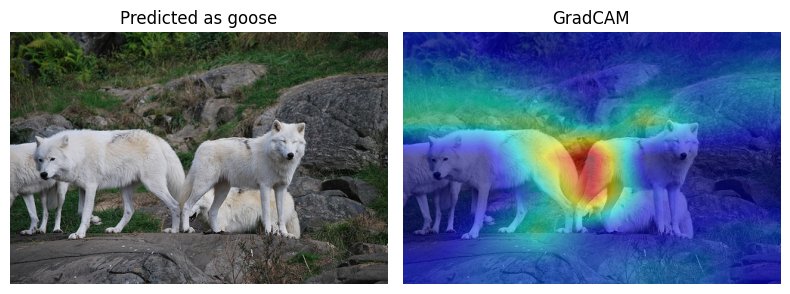

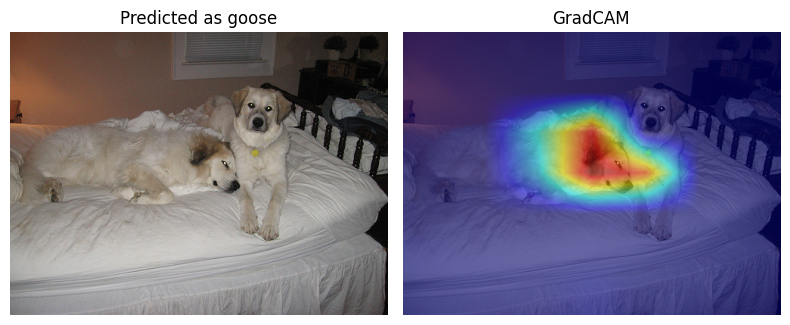

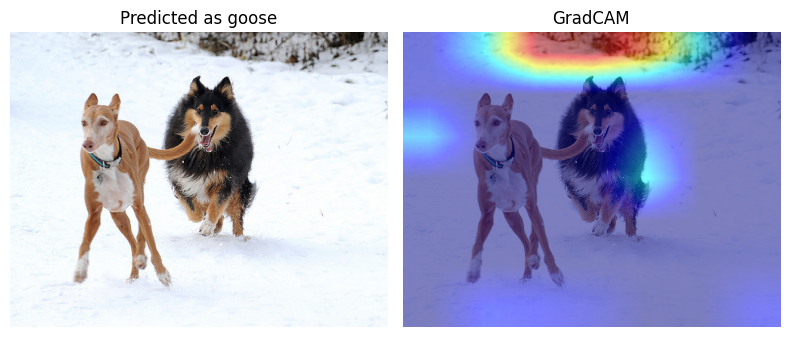

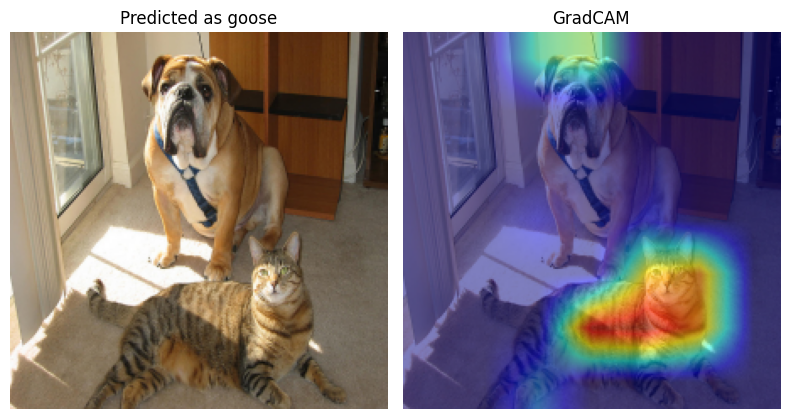

In [ ]:
for idx in range(len(result_list)):
  img_path = result_list[idx]["img_path"]
  out_class = result_list[idx]["out_class"]
  grad_cam_arr = result_list[idx]["grad_cam_arr"]

  img_original = Image.open(img_path).convert('RGB')
  out_series = pd.Series(out_class).value_counts()
  out_df = pd.DataFrame(out_series, columns=["count"], index=out_series.index).reset_index()
  predicted_label = pd.Series(out_class).value_counts().index[0]

  grad_cam_heatmap = np.squeeze(grad_cam_arr, axis=0)
  fig, axes = plt.subplots(1, 2, figsize = (8, 8))
  axes = axes.flatten()
  axes[0].imshow(img_original)
  axes[0].set_title(f"Predicted as {predicted_label}")
  #axes[1].imshow(np.linalg.norm(grad_cam_heatmap, axis=-1, ord=2))
  axes[1].imshow(grad_cam_heatmap)
  axes[1].set_title(f"GradCAM")
  for i in range(2):
    axes[i].axis("off")
  fig.tight_layout()
  plt.show()

In [ ]:
Xtest1 = torch.ones([334,500, 3])

In [ ]:
Xtest_np = Xtest1.cpu().detach().numpy().astype(np.float32)

In [ ]:
np.ndim(Xtest_np)

3

## GradCAM 전체 사진 실험


#### 원래는 MC GradCAM에서 각 사진에 대해 예측된 클래스에 대해서 최대 3개까지 값을 받아와서, 받아온 값에 대해 GradCAM을 계산해야 하지만,

#### 시간 관계상 우선 get_class_score 함수에 대해 out.max(1),out.max(2),out.max(3) 으로 값을 바꿔가는 식으로 일일이 계산하도록 한다. -> 이건 실패했다.

#### 시간 관계상 우선 사진 몇개 정해놓고 그 값에 해당하는 GradCAM일일이 계산하도록 하자. (개노가다) -> pickle로 결과를 저장하지는 말자.

In [ ]:
import os

path1='/content/drive/MyDrive/DLSP_Uncertainty_Quantification/MCGradCAM-testset/test'
lst1 = os.listdir(path1)
lst1 = sorted(lst1)
img_list_O = []
for i, filename in enumerate(lst1, start=1):
    img_path = f"{path1}/{filename}"
    globals()[f'img_path{i}'] = img_path
    img_list_O.append(img_path)

In [ ]:
path2='/content/drive/MyDrive/DLSP_Uncertainty_Quantification/MCGradCAM-testset/test-tf'
lst2 = os.listdir(path2)
lst2 = sorted(lst2)
img_list_T = []
for i, filename in enumerate(lst2, start=1):
    img_path = f"{path2}/{filename}"
    globals()[f'img_path{i}'] = img_path
    img_list_T.append(img_path)

In [ ]:
from tqdm import tqdm
import cv2
import os

device = torch.device("cuda")
dtype = torch.bfloat16
gradcam = GradCAM(model, device=device, dtype=dtype)

In [ ]:
import pandas as pd
import seaborn as sns

import matplotlib.cm as cm
from torchvision.transforms import Resize

#### Original data

In [ ]:
SEED = 77
torch_fix_seed(SEED)
result_listO = []
img_list = img_list_O
bs = 1
num_bs = 1

for i, img_path_ in enumerate(img_list, 1):
  result_dict_O = {}
  img_tensor = gradcam.load_img(img_path=img_path_)
  if img_tensor.dtype != gradcam.dtype:
      img_tensor = img_tensor.to(gradcam.dtype)
  result_dict_O["img_path"] = img_path_
  result_dict_O["grad_cam_heatmap"] = []
  result_dict_O["out_class"] = []
  for batch_idx in range(num_bs):
    img_tensors = torch.cat([img_tensor for _ in range(bs)])
    heatmap, predicted_class, img_np = gradcam.run_grad_cam(img_path = img_path_, img_class = 258)
    out_class = [class_idx_to_name[pred_cls.item()] for pred_cls in predicted_class]
    grad_cam_heatmap = gradcam.show_cam_on_image(img=img_np, mask=heatmap, use_rgb=True, colormap=cv2.COLORMAP_JET, image_weight=0.5)
    result_dict_O["grad_cam_heatmap"].append(grad_cam_heatmap)
    result_dict_O["out_class"] += out_class
  result_dict_O["grad_cam_arr"] = np.stack(result_dict_O["grad_cam_heatmap"])
  result_listO.append(result_dict_O)
  #print(f"{i}번째 사진 완료")

In [ ]:
# import pickle
# path_GradCAM_originaldata = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/path_GradCAM_originaldata'
# #os.makedirs(os.path.dirname(path_GradCAM_originaldata), exist_ok=True)
# with open(path_GradCAM_originaldata + '/result_listO.pkl', 'wb') as f:
#     pickle.dump(result_listO, f)

In [ ]:
save_plot_dir = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231228/plot_GradCAM_hyena'
os.makedirs(save_plot_dir, exist_ok=True)

In [ ]:
for idx in range(len(result_listO)):
  img_path = result_listO[idx]["img_path"]
  out_class = result_listO[idx]["out_class"]
  grad_cam_arr = result_listO[idx]["grad_cam_arr"]

  img_original = Image.open(img_path).convert('RGB')
  out_series = pd.Series(out_class).value_counts()
  out_df = pd.DataFrame(out_series, columns=["count"], index=out_series.index).reset_index()
  predicted_label = pd.Series(out_class).value_counts().index[0]

  grad_cam_heatmap = np.squeeze(grad_cam_arr, axis=0)
  fig, axes = plt.subplots(1, 2, figsize = (8, 8))
  axes = axes.flatten()
  axes[0].imshow(img_original)
  axes[0].set_title(f"Predicted as {predicted_label}")
  #axes[1].imshow(np.linalg.norm(grad_cam_heatmap, axis=-1, ord=2))
  axes[1].imshow(grad_cam_heatmap)
  axes[1].set_title(f"GradCAM")
  for i in range(2):
    axes[i].axis("off")
  fig.tight_layout()
  save_filename = os.path.join(save_plot_dir, f"hyena_{idx}.png")
  plt.savefig(save_filename, bbox_inches='tight')
  plt.close(fig)

#### Transformed data

In [ ]:
SEED = 77
torch_fix_seed(SEED)
result_listT = []
img_list = img_list_T
bs = 1
num_bs = 1

for img_path_ in img_list:
  result_dictT = {}
  img_tensor = gradcam.load_img(img_path=img_path_)
  if img_tensor.dtype != gradcam.dtype:
      img_tensor = img_tensor.to(gradcam.dtype)
  result_dictT["img_path"] = img_path_
  result_dictT["grad_cam_heatmap"] = []
  result_dictT["out_class"] = []
  for batch_idx in range(num_bs):
    img_tensors = torch.cat([img_tensor for _ in range(bs)])
    heatmap, predicted_class, img_np = gradcam.run_grad_cam(img_path = img_path_, img_class = 270)
    out_class = [class_idx_to_name[pred_cls.item()] for pred_cls in predicted_class]
    grad_cam_heatmap = gradcam.show_cam_on_image(img=img_np, mask=heatmap, use_rgb=True, colormap=cv2.COLORMAP_JET, image_weight=0.5)
    result_dictT["grad_cam_heatmap"].append(grad_cam_heatmap)
    result_dictT["out_class"] += out_class
  result_dictT["grad_cam_arr"] = np.stack(result_dictT["grad_cam_heatmap"])
  result_listT.append(result_dictT)

In [ ]:
# import pickle
# path_GradCAM_transformdata = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231208/path_GradCAM_transformdata'
# #os.makedirs(os.path.dirname(path_GradCAM_transformdata), exist_ok=True)
# with open(path_GradCAM_transformdata + '/result_listT.pkl', 'wb') as f:
#     pickle.dump(result_listT, f)

In [ ]:
save_plot_dir = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231228/plot_GradCAM_white_wolf'
os.makedirs(save_plot_dir, exist_ok=True)

In [ ]:
for idx in range(len(result_listO)):
  img_path = result_listO[idx]["img_path"]
  out_class = result_listO[idx]["out_class"]
  grad_cam_arr = result_listO[idx]["grad_cam_arr"]

  img_original = Image.open(img_path).convert('RGB')
  out_series = pd.Series(out_class).value_counts()
  out_df = pd.DataFrame(out_series, columns=["count"], index=out_series.index).reset_index()
  predicted_label = pd.Series(out_class).value_counts().index[0]

  grad_cam_heatmap = np.squeeze(grad_cam_arr, axis=0)
  fig, axes = plt.subplots(1, 2, figsize = (8, 8))
  axes = axes.flatten()
  axes[0].imshow(img_original)
  axes[0].set_title(f"Predicted as {predicted_label}")
  #axes[1].imshow(np.linalg.norm(grad_cam_heatmap, axis=-1, ord=2))
  axes[1].imshow(grad_cam_heatmap)
  axes[1].set_title(f"GradCAM")
  for i in range(2):
    axes[i].axis("off")
  fig.tight_layout()
  save_filename = os.path.join(save_plot_dir, f"white_wolf_{idx}.png")
  plt.savefig(save_filename, bbox_inches='tight')
  plt.close(fig)

## FC dropout Grad-CAM

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
from torch import nn,Tensor
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2

class FCDropoutGradCAM:
    def __init__(self, model, dtype=torch.float32, device=torch.device("cpu")):
        self.feature_maps = None
        self.dtype = dtype
        self.device = device

        # devide model components
        self.feature_extractor = nn.Sequential(
            model.features,
            model.avgpool)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            model.classifier
        )
        self.feature_extractor.eval()
        self.classifier.train()
        self.to(device, dtype=dtype)
        self.classifier_train = True

    def to(self, device, dtype=torch.float32):
        self.feature_extractor = self.feature_extractor.to(device, dtype=dtype)
        self.classifier = self.classifier.to(device, dtype=dtype)


    # 클래스 스코어 추출 함수
    def get_class_score(self, img_tensor, bs=1):
        # consider img_tensor = [1, n_c , imgd1, imgd2]
        with torch.cuda.amp.autocast():
          self.feature_extractor.zero_grad()
          self.classifier.zero_grad()

          # 이미지 전처리 및 requires_grad 설정
          img_tensor.requires_grad_(True)
          with torch.no_grad():
            Ak = self.feature_extractor(img_tensor)
          # Ak: [1, nc, fs, fs]
          Aks = Ak.clone().repeat([bs, 1, 1, 1])
          Aks.requires_grad_(True)
          out = self.classifier(Aks)
          _, predicted_class = out.max(1)
          score = out[:, predicted_class]
          score_out = score.sum()
          score_out.backward()
          grad_Aks = Aks.grad

        return predicted_class, score, Aks, grad_Aks, out

    # Grad-CAM 계산기
    def calculate_grad_cam(self, Ak, gradients, target_size):
        # 그라디언트의 글로벌 평균 계산 (by channel)
        alpha_c_k = torch.mean(gradients, dim=[2, 3])
        # [n_channel]

        # # feature maps에 그라디언트 가중치를 곱하여 클래스의 activation map 생성
        # weighted_feature_maps = Ak * alpha_c_k[:, None, None]
        # # [bs, n_channel, feat_dim, feat_dim]

        # # 클래스별 가중 feature maps의 채널별 합산
        # heatmap = torch.sum(weighted_feature_maps, dim=1).squeeze()
        heatmap = torch.einsum('ij,ijkl->ikl', alpha_c_k, Ak)

        # ReLU 적용 - 음수 값 제거
        heatmap = torch.relu(heatmap)

        # heatmap을 [0, 1] 범위로 정규화
        heatmap_min = torch.min(heatmap)
        heatmap_max = torch.max(heatmap)
        heatmap = (heatmap - heatmap_min) / (heatmap_max - heatmap_min)

        # heatmap을 target_size로 리사이징
        # print("resize 이전 히트맵 크기 (bs, width, height): ", np.shape(heatmap))
        heatmap = heatmap.unsqueeze(1)
        # print("unsqueeze 이후 히트맵 크기 (채널 차원 추가 : bs, c, width, height) : ", np.shape(heatmap))
        heatmap = F.interpolate(heatmap, size=target_size, mode='bilinear', align_corners=False)
        heatmap = heatmap.squeeze(1)
        # print("resize 이후 히트맵 크기 (채널 차원 제거 : bs, width, height) : ", np.shape(heatmap))

        #return heatmap.cpu().detach().numpy().astype(np.float32)
        return heatmap

    def load_img(self, img_path):
        # 이미지 전처리 및 requires_grad 설정
        img = Image.open(img_path).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])
        img_preprocessed = preprocess(img).to(self.dtype)  # 여기에 .to(self.dtype) 추가
        img_preprocessed = img_preprocessed.unsqueeze(0).to(self.device, self.dtype)  # 이미지를 모델의 데이터 타입과 디바이스로 이동
        img_preprocessed.requires_grad_(True)
        return img_preprocessed

    def run_mc_grad_cam(self, img_path=None, img_tensor=None, nmc=10, bs=None):
        img = Image.open(img_path)

        if img_path is not None:
            img_tensor = self.load_img(img_path)
            img_np = np.array(img)
        else :
            img_np = np.array(img)

        if bs is None:
            bs = nmc

        if not self.classifier_train:
            self.to_train_mode()

        if nmc % bs != 0:
            raise NotImplementedError
        else:
            num_batch = nmc // bs

        # assume img_tensor = [img_tensor_1, img_tensor_2, ...] = [num_img, n_channel, img_dim1, img_dim2]
        # 클래스와 해당 스코어 추출

        target_size = np.shape(img_np)
        # print("targrt_size 변형전 : ", target_size)
        if len(target_size) == 3:
            target_size = np.shape(img_np[:,:,0])
        else :
            target_size = np.shape(img_np)


        target_size = np.shape(img_np[:,:,0])
        # print("target_size 변형후 : ", target_size)

        pred_list = []
        grad_cam_list = []
        grad_cam_mean = None
        grad_cam_std = None

        for mini_batch in range(num_batch):
            predicted_class, score, Aks, grad_Aks, out = self.get_class_score(img_tensor, bs)
            grad_cam_list.append(self.calculate_grad_cam(Aks, grad_Aks, target_size))
            pred_list.append(predicted_class)

        grad_cam_t = torch.cat(grad_cam_list)
        pred_t = torch.cat(pred_list)



        return grad_cam_t, pred_t, img_np

    def to_eval_mode(self):
        if self.classifier_train:
            self.classifier.eval()
            self.classifier_train = False

    def to_train_mode(self):
        self.classifier.train()
        self.classifier_train = True


    def show_cam_on_image(self, img: np.ndarray, mask: np.ndarray, use_rgb: bool = False, colormap: int = cv2.COLORMAP_JET, image_weight: float = 0.5) -> np.ndarray:
        """ This function overlays the cam mask on the image as an heatmap.
        By default the heatmap is in BGR format.

        :param img: The base image in RGB or BGR format.
        :param mask: The cam mask.
        :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
        :param colormap: The OpenCV colormap to be used.
        :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
        :returns: The default image with the cam overlay.
        """
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().detach().numpy().astype(np.float32)
        else:
            mask = mask.astype(np.float32)

        mask = (mask - mask.min()) / (mask.max() - mask.min())
        img = img / 255.0

        heatmap = cv2.applyColorMap(np.uint8(255.0 * mask), colormap)
        if use_rgb:
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = np.float32(heatmap) / 255.0

        if np.max(img) > 1:
            raise Exception(
                "The input image should np.float32 in the range [0, 1]")

        if image_weight < 0 or image_weight > 1:
            raise Exception(
                f"image_weight should be in the range [0, 1].\
                    Got: {image_weight}")

        # 원본 이미지가 흑백인 경우 채널 차원을 추가
        if len(img.shape) == 2:
            img = img[:, :, np.newaxis]  # (H, W) -> (H, W, 1)

        # 이미지가 흑백이면서 채널 차원을 추가한 경우, 이 차원을 히트맵의 채널 수에 맞게 복제
        if img.shape[2] == 1:
            img = np.repeat(img, 3, axis=2)  # (H, W, 1) -> (H, W, 3)


        cam = (1 - image_weight) * heatmap + image_weight * img
        cam = cam / np.max(cam)
        return np.uint8(255 * cam)



    def show_uncertainty_on_image(self, img: np.ndarray, mask: np.ndarray, use_rgb: bool = False, colormap: int = cv2.COLORMAP_JET, image_weight: float = 0.5) -> np.ndarray:
        """ This function overlays the cam mask on the image as an heatmap.
        By default the heatmap is in BGR format.

        :param img: The base image in RGB or BGR format.
        :param mask: The cam mask.
        :param use_rgb: Whether to use an RGB or BGR heatmap, this should be set to True if 'img' is in RGB format.
        :param colormap: The OpenCV colormap to be used.
        :param image_weight: The final result is image_weight * img + (1-image_weight) * mask.
        :returns: The default image with the cam overlay.
        """
        if isinstance(mask, torch.Tensor):
            mask = mask.cpu().detach().numpy().astype(np.float32)
        else:
            mask = mask.astype(np.float32)

        mask = (mask - mask.min()) / (mask.max() - mask.min())
        img = img / 255.0

        heatmap = cv2.applyColorMap(np.uint8(255.0 * mask), colormap)
        if use_rgb:
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        heatmap = np.float32(heatmap) / 255.0

        if np.max(img) > 1:
            raise Exception(
                "The input image should np.float32 in the range [0, 1]")

        if image_weight < 0 or image_weight > 1:
            raise Exception(
                f"image_weight should be in the range [0, 1].\
                    Got: {image_weight}")

        # 원본 이미지가 흑백인 경우 채널 차원을 추가
        if len(img.shape) == 2:
            img = img[:, :, np.newaxis]  # (H, W) -> (H, W, 1)

        # 이미지가 흑백이면서 채널 차원을 추가한 경우, 이 차원을 히트맵의 채널 수에 맞게 복제
        if img.shape[2] == 1:
            img = np.repeat(img, 3, axis=2)  # (H, W, 1) -> (H, W, 3)


        cam = (1 - image_weight) * heatmap + image_weight * img
        cam = cam / np.max(cam)
        return np.uint8(255 * cam)

## MC-GradCAM 전체 사진 실험

In [ ]:
from tqdm import tqdm
import cv2
import os

device = torch.device("cuda")
dtype = torch.bfloat16
fc_dropout_gradcam = FCDropoutGradCAM(model, device=device, dtype=dtype)

In [ ]:
def calc_cls_entropy(prob):
  return -(prob * np.log(prob)).sum()

#### Original data

In [ ]:
import gc

In [ ]:
path3='/content/drive/MyDrive/DLSP_Uncertainty_Quantification/MCGradCAM-testset/test_for_thesis'
lst3 = os.listdir(path3)
lst3 = sorted(lst3)
img_list_mcg = []
for i, filename in enumerate(lst3, start=1):
    img_path = f"{path3}/{filename}"
    globals()[f'img_path{i}'] = img_path
    img_list_mcg.append(img_path)

In [ ]:
SEED = 77
torch_fix_seed(SEED)
mcd_result_list = []
img_list = img_list_mcg
# img_list = [img_path1 for _ in range(1000)]

T = 2500
# T = bs * num_bs
num_bs = 5
bs = int(T / num_bs)

for i, img_path_ in enumerate(img_list, 1):
  mcd_result_dict = {}
  img_tensor = fc_dropout_gradcam.load_img(img_path=img_path_)
  mcd_result_dict["img_path"] = img_path_
  mcd_result_dict["img_tensor"] = img_tensor.cpu()
  heatmap, predicted_class, img_np = fc_dropout_gradcam.run_mc_grad_cam(img_path=img_path_, nmc=T, bs=bs)
  mcd_result_dict["heatmap"] = heatmap.detach().cpu().numpy()
  mcd_result_dict["predicted_class"] = predicted_class.detach().cpu().numpy()
  mcd_result_dict["img_np"] = img_np

  out_class = mcd_result_dict["predicted_class"]
  mc_heatmap = mcd_result_dict["heatmap"]

  out_series = pd.Series(out_class).value_counts()
  out_df = pd.DataFrame(out_series, columns=["count"], index=out_series.index).reset_index()
  out_df["index"] = [class_idx_to_name[out_ind] for out_ind in out_df["index"]]
  out_df.index = out_df["index"]
  predicted_label = class_idx_to_name[pd.Series(out_class).value_counts().index[0]]
  out_df["prob"] = out_df["count"] / out_df["count"].sum()

  mcd_result_dict["out_df"] = out_df
  mcd_result_dict["cls_entropy"] = calc_cls_entropy(out_df["prob"].values)

  # Initialize a dictionary to hold heatmaps for each class
  heatmaps_by_class = {class_name: [] for class_name in out_df['index']}

  # Group heatmaps by predicted class
  for pred_class, heatmap in zip(out_class, mc_heatmap):
      class_name = class_idx_to_name[pred_class]
      if class_name in heatmaps_by_class:
          heatmaps_by_class[class_name].append(heatmap)
      else:
          heatmaps_by_class[class_name] = [heatmap]

  mcd_result_dict["heatmaps_by_class_list"] = heatmaps_by_class

  mcd_result_list.append(mcd_result_dict)

  # del img_tensor, heatmap, predicted_class, img_np, mc_heatmap
  # gc.collect()
  # # torch.cuda.empty_cache()
  print(f"{i}번째 사진 완료")

1번째 사진 완료
2번째 사진 완료
3번째 사진 완료
4번째 사진 완료
5번째 사진 완료
6번째 사진 완료


In [ ]:
import pandas as pd
import seaborn as sns
from PIL import Image

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [ ]:
save_plot_dir = '/content/drive/MyDrive/DLSP_Uncertainty_Quantification/Final/20231228/plot_MC_GradCAM_for_thesis'
os.makedirs(save_plot_dir, exist_ok=True)

In [ ]:
device = torch.device("cuda")
dtype = torch.float32

In [ ]:
heatmaps_by_class_list = []
mc_grad_cam_heatmap_list = []

for idx in range(len(mcd_result_list)):
  # 올바른 시각화를 위한 히트맵 리스트 초기화
  mc_grad_cam_heatmap_list = []
  mc_grad_cam_variance_list = []
  mc_grad_cam_totalmap_list = []

  total_heatmap = mcd_result_list[idx]["heatmap"]
  img_path = mcd_result_list[idx]["img_path"]
  img_np = mcd_result_list[idx]["img_np"]
  heatmaps_by_class = mcd_result_list[idx]["heatmaps_by_class_list"]
  cls_entropy = mcd_result_list[idx]["cls_entropy"]
  out_df = mcd_result_list[idx]["out_df"]

  img_original = Image.open(img_path).convert('RGB')


  total_heatmap_np = np.array(total_heatmap)
  total_heatmap_tensor = torch.from_numpy(total_heatmap_np).to(device=device, dtype=dtype)
  mc_grad_cam_var_heatmap = torch.std(total_heatmap_tensor, axis=0).cpu().numpy()
  print("mc_grad_cam_var Shape : ", np.shape(mc_grad_cam_var_heatmap) )
  mc_grad_cam_variance = fc_dropout_gradcam.show_uncertainty_on_image(img=img_np, mask=mc_grad_cam_var_heatmap, use_rgb=True, colormap=cv2.COLORMAP_JET, image_weight=0.5)
  #mc_grad_cam_variance = (mc_grad_cam_variance - mc_grad_cam_variance.min()) / (mc_grad_cam_variance.max() - mc_grad_cam_variance.min())
  mc_grad_cam_variance_array = (mc_grad_cam_variance, 'Uncertainty')

  mc_grad_cam_heatmap_list.append(mc_grad_cam_variance_array)

  for class_name in heatmaps_by_class:

    heatmaps_np = np.array(heatmaps_by_class[class_name])
    # GPU 계산
    #heatmaps_tensor = torch.tensor(heatmaps_by_class[class_name], device=device, dtype=dtype)
    #heatmaps_tensor = torch.tensor(heatmaps_np).to(device=device, dtype=dtype)

    heatmaps_tensor = torch.from_numpy(heatmaps_np).to(device=device, dtype=dtype)


    mc_grad_cam_mean_heatmap = torch.mean(heatmaps_tensor, axis=0).cpu().numpy()


    mc_grad_cam_heatmap = fc_dropout_gradcam.show_cam_on_image(img=img_np, mask=mc_grad_cam_mean_heatmap, use_rgb=True, colormap=cv2.COLORMAP_JET, image_weight=0.5)
    mc_grad_cam_heatmap_list.append((mc_grad_cam_heatmap, class_name))  # Append heatmap along with class name


###시각화 부분


  # Create figure and GridSpec with dynamic column size
  num_heatmaps = len(mc_grad_cam_heatmap_list)
  num_columns = max(4, num_heatmaps)  # At least 3 columns for original and up to 2 heatmaps
  if num_columns >= 5:
    num_columns = 5
  else:
    num_columns = num_columns

  fig = plt.figure(figsize=(16, 8))
  gs = GridSpec(2, num_columns + 1, figure=fig)  # +1 for the bar chart

  # Add original image to the first row spanning two columns
  ax_original = fig.add_subplot(gs[0:1, :2])
  ax_original.imshow(img_original)
  ax_original.set_title("Original Photo")
  ax_original.axis('off')

  print("num_columns : ", num_columns)


  if len(mc_grad_cam_heatmap_list) == 1:
    for i, (heatmap, class_name) in enumerate(mc_grad_cam_heatmap_list[:num_columns-1]):
      if i == num_columns-1 :
        ax_heatmap = fig.add_subplot(gs[0, 2 + i])
        ax_heatmap.imshow(heatmap)  # Placeholder for actual heatmap
        ax_heatmap.set_title(f"{class_name}")
        ax_heatmap.axis('off')
      else :
        ax_heatmap = fig.add_subplot(gs[0, 2 + i])
        ax_heatmap.imshow(heatmap)  # Placeholder for actual heatmap
        ax_heatmap.set_title(f"MC-GradCAM: {class_name}")
        ax_heatmap.axis('off')


  elif len(mc_grad_cam_heatmap_list) == 2:
    for i, (heatmap, class_name) in enumerate(mc_grad_cam_heatmap_list[:num_columns-1]):
      if i == num_columns-1 :
        ax_heatmap = fig.add_subplot(gs[0, 2 + i])
        ax_heatmap.imshow(heatmap)  # Placeholder for actual heatmap
        ax_heatmap.set_title(f"{class_name}")
        ax_heatmap.axis('off')
      else :
        ax_heatmap = fig.add_subplot(gs[0, 2 + i])
        ax_heatmap.imshow(heatmap)  # Placeholder for actual heatmap
        ax_heatmap.set_title(f"MC-GradCAM: {class_name}")
        ax_heatmap.axis('off')
  else :
    for i, (heatmap, class_name) in enumerate(mc_grad_cam_heatmap_list[:num_columns-1]):
      if i == num_columns-1 :
        ax_heatmap = fig.add_subplot(gs[0, 2 + i])
        ax_heatmap.imshow(heatmap)  # Placeholder for actual heatmap
        ax_heatmap.set_title(f"{class_name}")
        ax_heatmap.axis('off')
      else :
        ax_heatmap = fig.add_subplot(gs[0, 2 + i])
        ax_heatmap.imshow(heatmap)  # Placeholder for actual heatmap
        ax_heatmap.set_title(f"MC-GradCAM: {class_name}")
        ax_heatmap.axis('off')


  # Add bar plot in the second row spanning all columns
  ax_bar = fig.add_subplot(gs[1, :])
  sns.barplot(x='index', y='count', data=out_df, ax=ax_bar)
  ax_bar.set_title("Predictive Entropy")
  ax_bar.set_xticklabels(ax_bar.get_xticklabels(), rotation=45, ha='right')

  # Adjust layout
  fig.tight_layout()
  save_filename = os.path.join(save_plot_dir, f"plot_{idx}.png")
  plt.savefig(save_filename, bbox_inches='tight')
  plt.close(fig)




mc_grad_cam_var Shape :  (334, 500)
num_columns :  4
mc_grad_cam_var Shape :  (391, 500)
num_columns :  5
mc_grad_cam_var Shape :  (375, 500)
num_columns :  5
mc_grad_cam_var Shape :  (375, 500)
num_columns :  4
mc_grad_cam_var Shape :  (500, 453)
num_columns :  4
mc_grad_cam_var Shape :  (364, 360)
num_columns :  4
